## load modules and pretrained 99.25% accuracy CNN

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras.models import load_model
from keras import backend as K

model = load_model('/Users/zetong/cnn.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


## helper functions

In [39]:
# load the image from MNIST dataset into [1,28,28,1] dimension
def load_image(image_location):
    x = np.asarray(PIL.Image.open(image_location))
    x = x.reshape(28,28)
    x = x.reshape(1, 28, 28, 1)
    x = x.astype('float32')
    x /= 255
    return x

# putting the adversarial examples and their misclassification labels in subplots
def plot_adversarials(attacks, predicted_labels):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = len(attacks)
    rows = 1
    for i in range(1, columns*rows+1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(str(predicted_labels[i-1]))
        plt.imshow(attacks[i-1].reshape((28,28)), cmap='Greys')
    plt.show()
    return

# a helper function to visualize a list of adversarial examples
def visualize_adversarials(attacks):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = len(attacks)
    rows = 1
    for i in range(1, columns*rows+1):
        ax = fig.add_subplot(rows, columns, i)
        plt.imshow(attacks[i-1].reshape((28,28)), cmap='Greys')
    plt.show()
    return

## Carlini&Wagner L2 attack

In [46]:
class cwl2:
    def __init__(self, sess, model, K=0, max_iterations=1000, step_size=0.1, initial_cost=10, SEARCH_STEPS=9):
        self.sess = sess
        self.model = model
        self.K = K
        self.max_iterations = max_iterations
        self.step_size = step_size
        self.initial_cost = initial_cost
        self.SEARCH_STEPS = SEARCH_STEPS
    
    # return the logits tensor and the nontarget index logits tensor
    def get_logits_and_nontarget_logits(self, x_new, target):
        logits = model(x_new)
        return logits, tf.concat([logits[0][0:target], logits[0][target:-1]], 0)
    
    # the loss function for l2 attack
    def loss(self, x_new, x, target, c):
        logits, nontarget_logits = self.get_logits_and_nontarget_logits(x_new, target)
        return tf.norm(x_new-x)**2 + c*tf.math.maximum(tf.math.reduce_max(nontarget_logits) - logits[0][target], -self.K)
        
    # search for the best adversarial examples
    def find_best_attack(self, model, x, target):
        # all the valid attacks
        attacks = []
        # initial c value
        c = self.initial_cost
        K = self.K
        for s in range(self.SEARCH_STEPS+1):
            x_new = tf.Variable(np.zeros([1,28,28,1]), dtype=tf.float32)
            loss = self.loss(x_new, x, target, c)
            train = tf.train.AdamOptimizer(self.step_size).minimize(loss, var_list=[x_new])
            self.sess.run(tf.global_variables_initializer())
            for i in range(self.max_iterations):
                self.sess.run(train)
                new_img = self.sess.run(x_new)
            # if the attack is sucessful
            if np.argmax(model.predict(new_img)) == target:
                # add it to the valid attacks collection
                attacks.append(new_img)
                # decrease c value to try to find an attack with less perturbation
                c = c*0.5
            # if the attack failed
            else:
                # increase c value to enforce the solver to find a sucessful attack
                c = c*10
            print(s, "/", self.SEARCH_STEPS, "search steps")
            print("c value:", c)
            print(len(attacks), "adversarials examples found")
        # let the best attack to be the one with the smallest perturbation
        noise_norms = []
        for i in range(len(attacks)):
            noise_norms.append(np.linalg.norm(attacks[i] - x))
        best_attack = attacks[np.argmin(noise_norms)]
        return best_attack, attacks

## attack demo

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x139d427f0>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


0 / 9 search steps
c value: 100
0 adversarials examples found
1 / 9 search steps
c value: 1000
0 adversarials examples found
2 / 9 search steps
c value: 500.0
1 adversarials examples found
3 / 9 search steps
c value: 5000.0
1 adversarials examples found
4 / 9 search steps
c value: 2500.0
2 adversarials examples found
5 / 9 search steps
c value: 1250.0
3 adversarials examples found
6 / 9 search steps
c value: 625.0
4 adversarials examples found
7 / 9 search steps
c value: 312.5
5 adversarials examples found
8 / 9 search steps
c value: 3125.0
5 adversarials examples found
9 / 9 search steps
c value: 1562.5
6 adversarials examples found
[[0.09649879 0.09789269 0.10224027 0.09195052 0.09175661 0.10086847
  0.10704794 0.10617716 0.09819039 0.10737721]]
[[0.09386873 0.09948298 0.10612319 0.08934749 0.08866507 0.09734549
  0.11022578 0.10723222 0.10056711 0.10714187]]
[[0.09534815 0.09864775 0.10341886 0.09201507 0.09144315 0.10078975
  0.10671934 0.10665387 0.09762836 0.10733566]]
[[0.095338

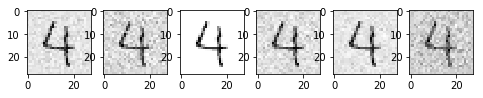

In [47]:
with tf.Session() as sess:
    x = load_image('/Users/zetong/mnist_png/testing/4/24.png')
    l2attack = cwl2(sess, model)
    best_attack, attacks = l2attack.find_best_attack(model, x, 0)
    for i in range(len(attacks)):
        print(model.predict(attacks[i]))
    visualize_adversarials(attacks)